In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#import corr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('datasets/all_seasons.csv')
expanded_allstars_df = pd.read_csv('datasets/expanded_allstars_fixed.csv')
df.head(5)

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


In [3]:
# Criar a coluna 'all_star' com base nos jogadores e temporadas do arquivo expandido do All-Star
def add_all_star_column(all_seasons_df, allstars_df):
    all_seasons_df['all_star'] = all_seasons_df.apply(
        lambda row: 1 if ((row['player_name'] in allstars_df['player_name'].values) and
                          (row['season'] in allstars_df[allstars_df['player_name'] == row['player_name']]['expanded_seasons'].values)) else 0,
        axis=1
    )
    return all_seasons_df

# Adicionar a coluna all_star
all_seasons = add_all_star_column(df, expanded_allstars_df)
all_seasons.drop(columns=["Unnamed: 0"], inplace=True)

# Salvar o arquivo atualizado
all_seasons.to_csv('all_seasons_with_all_star.csv', index=False)


## Pré-Processamento

In [4]:
all_seasons.isnull().sum()

player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
all_star                0
dtype: int64

In [5]:
# Substituindo as linhas nulas por "Unknow"
all_seasons['college'].fillna('Unknown', inplace=True)
all_seasons.isnull().sum()

/tmp/ipykernel_15967/2395091689.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_seasons['college'].fillna('Unknown', inplace=True)


player_name          0
team_abbreviation    0
age                  0
player_height        0
player_weight        0
college              0
country              0
draft_year           0
draft_round          0
draft_number         0
gp                   0
pts                  0
reb                  0
ast                  0
net_rating           0
oreb_pct             0
dreb_pct             0
usg_pct              0
ts_pct               0
ast_pct              0
season               0
all_star             0
dtype: int64

In [6]:
# Selecionando colunas numéricas
colunas_numericas = all_seasons.select_dtypes(include=['float64', 'int64']).columns

#Removendo a coluna all_star das númericas porque só assume dois valores (0 ou 1)
colunas_numericas = colunas_numericas.drop('all_star')
print(colunas_numericas)

Index(['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast',
       'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'],
      dtype='object')


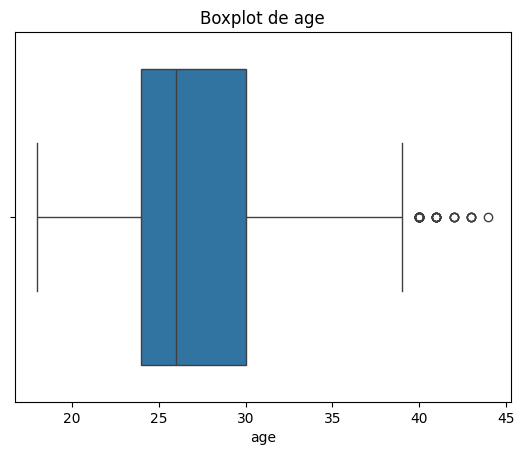

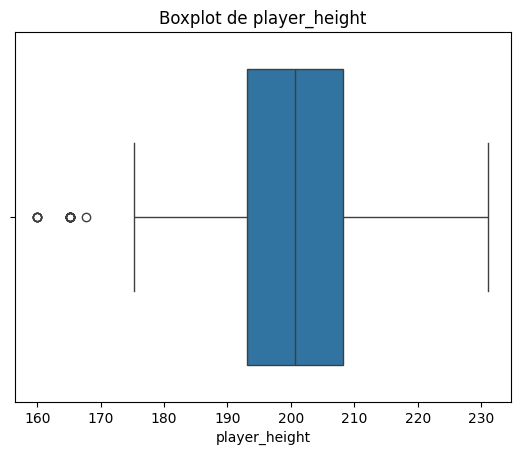

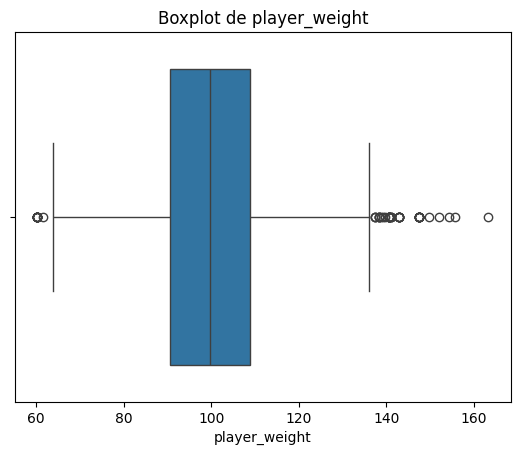

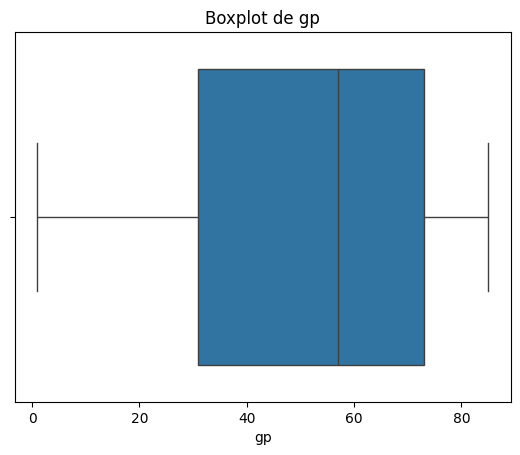

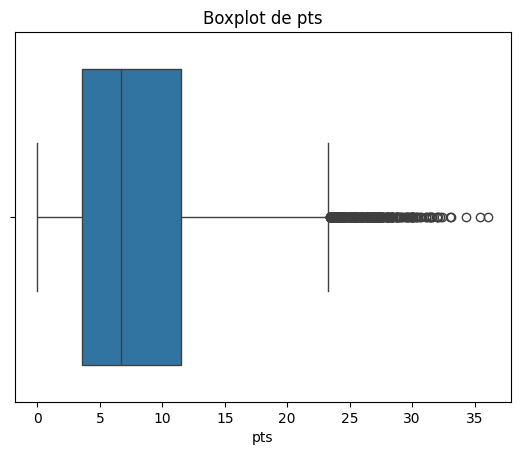

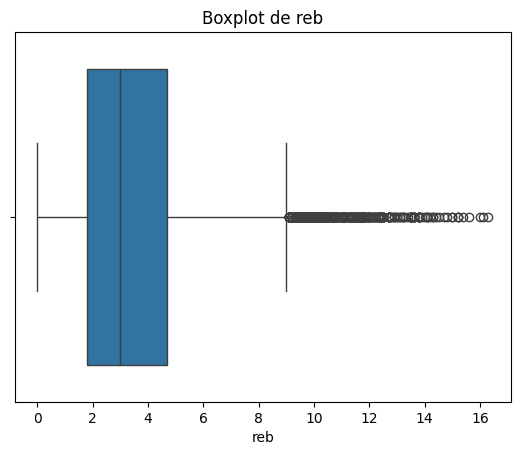

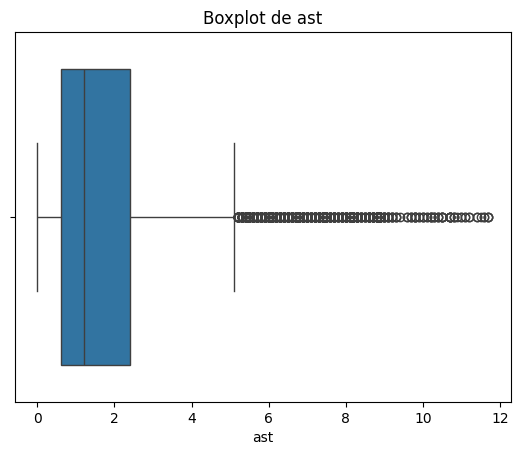

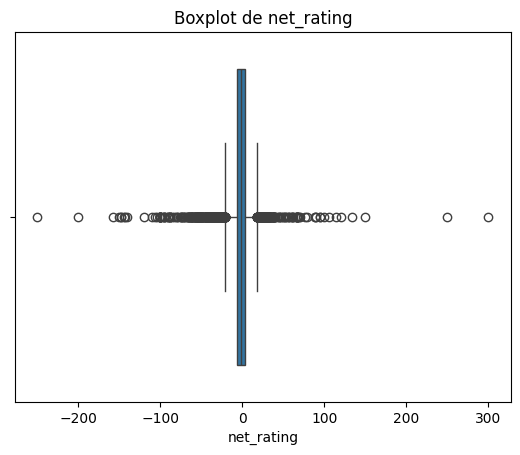

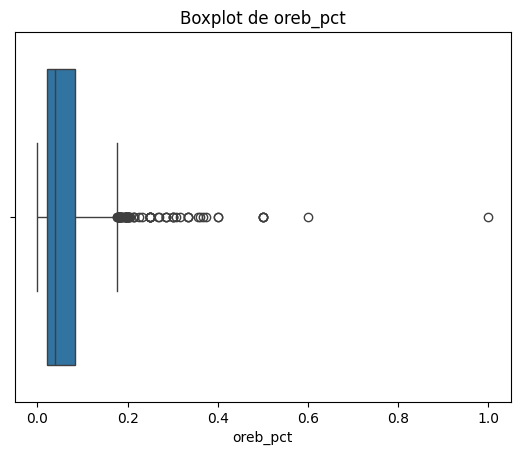

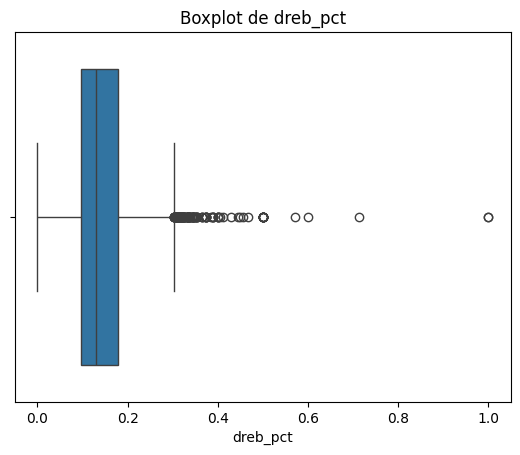

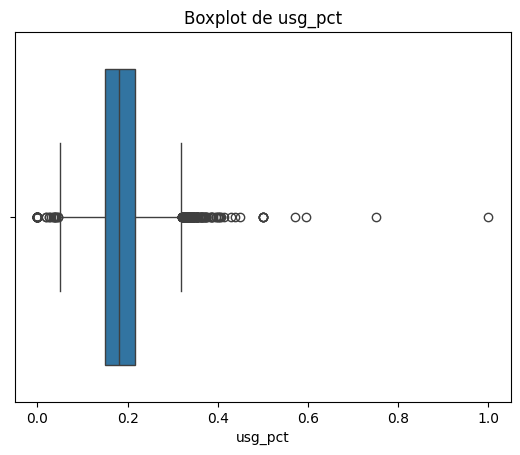

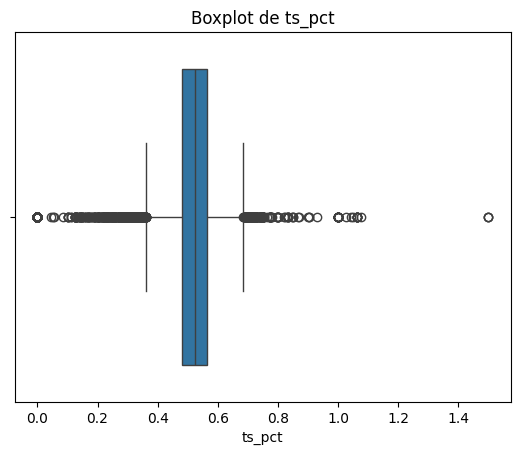

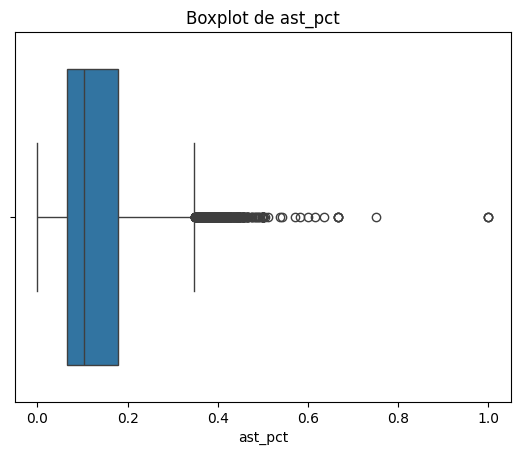

In [7]:
#Boxplot para visualizar outliers
for coluna in colunas_numericas:
    plt.figure()
    sns.boxplot(x=all_seasons[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.show()

In [8]:
# Loop para detectar e remover os outliers
for coluna in colunas_numericas:
    # Calcular Q1 (25º percentil) e Q3 (75º percentil)
    Q1 = all_seasons[coluna].quantile(0.25)
    Q3 = all_seasons[coluna].quantile(0.75)
    IQR = Q3 - Q1  # Intervalo interquartil

    # Limites para detectar outliers extremos
    limite_inferior = Q1 - 3.0 * IQR
    limite_superior = Q3 + 3.0 * IQR

    # Substituir outliers extremos pela média de sua ocorrência
    media_coluna = all_seasons[coluna].mean()
    all_seasons[coluna] = all_seasons[coluna].apply(lambda x: media_coluna if (x < limite_inferior or x > limite_superior) else x)

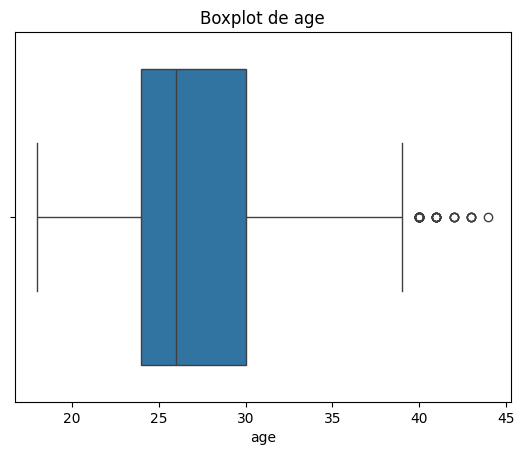

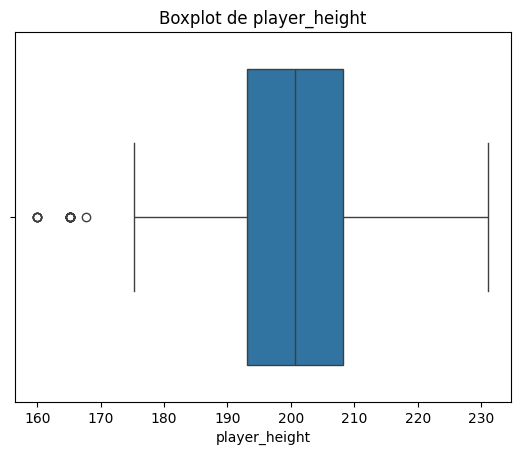

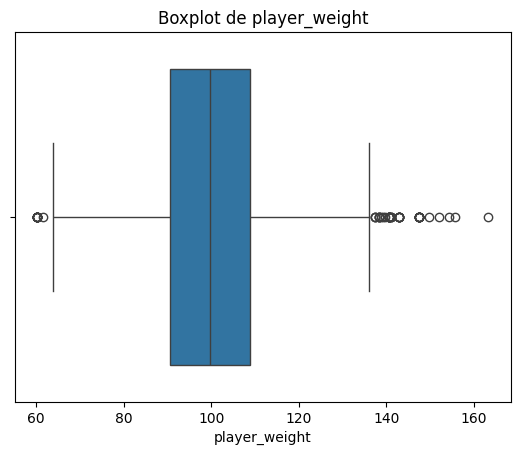

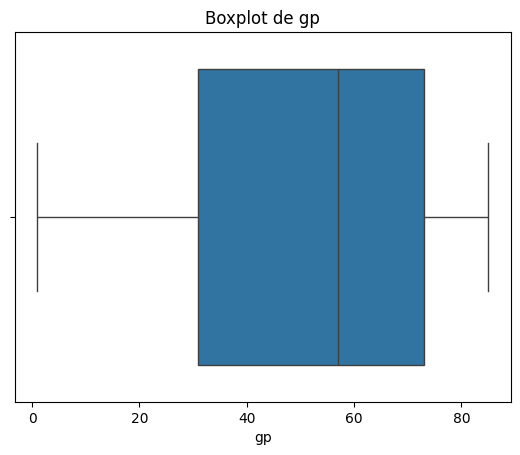

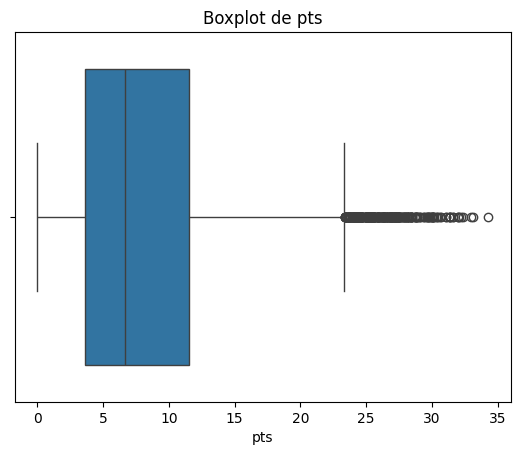

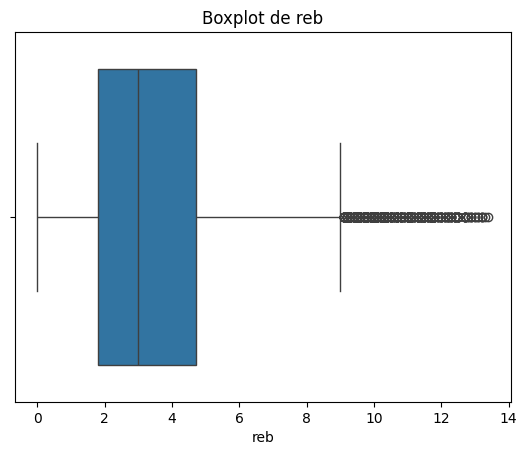

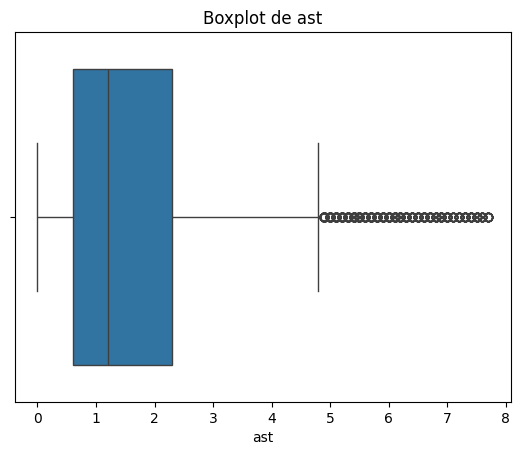

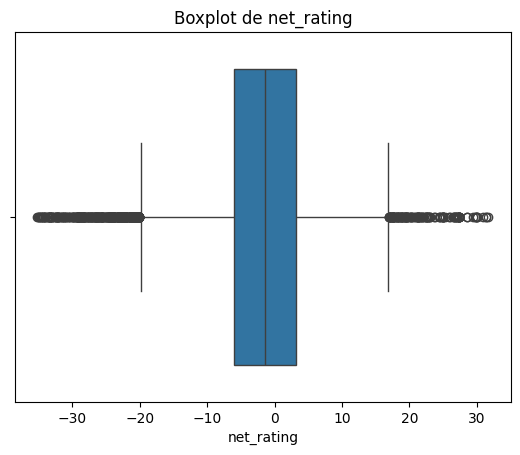

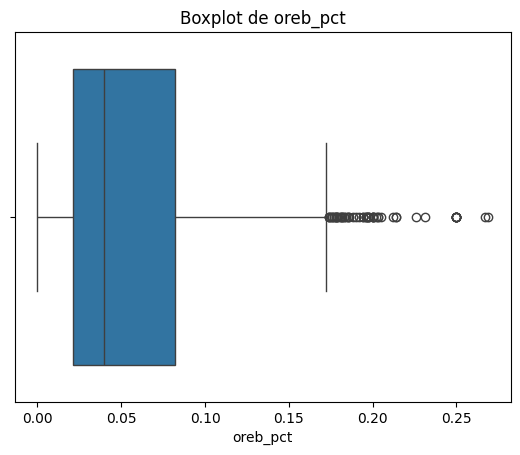

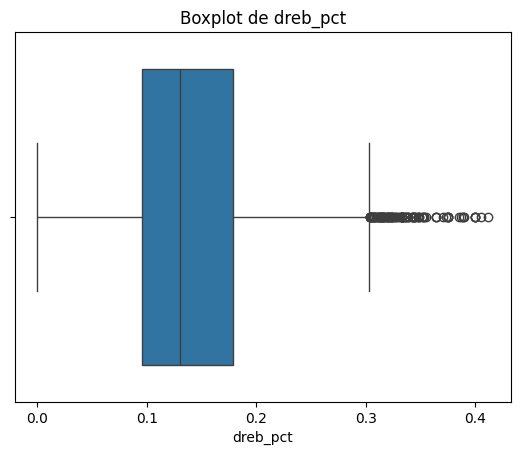

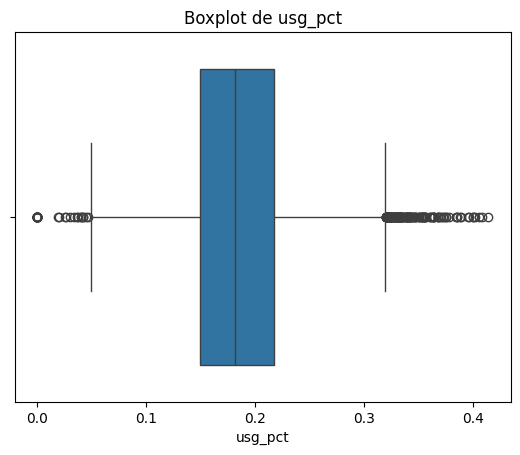

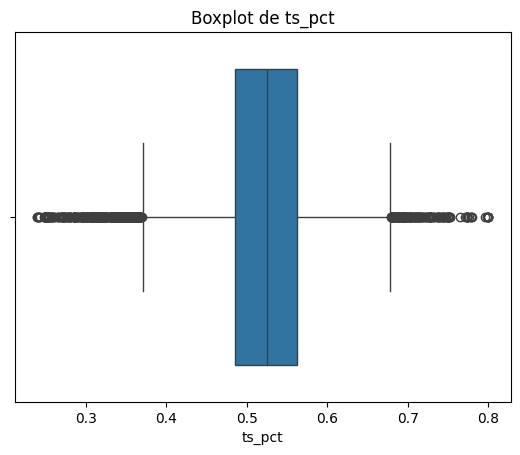

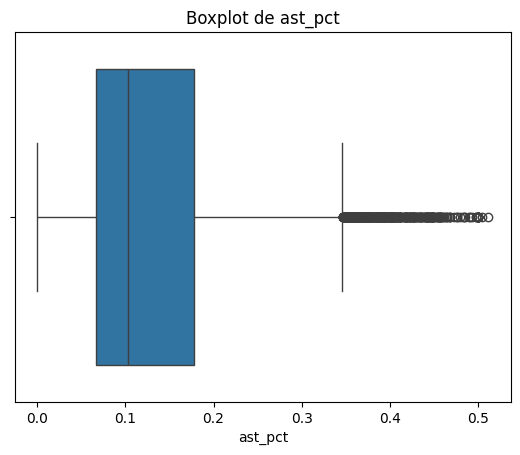

In [9]:
#Exibindo Boxplot após remover outliers extremos
for coluna in colunas_numericas:
    plt.figure()
    sns.boxplot(x=all_seasons[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.show()

## Iniciando a Análise Exploratória dos Dados

In [10]:
to_drop_columns = ["draft_number", "player_name", "team_abbreviation", "college", "season", "country", "draft_round", "draft_year"]

data = all_seasons.drop(columns=to_drop_columns)
data.head()

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,all_star
0,22.0,193.04,94.800728,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,0
1,28.0,190.50,86.182480,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,0
2,26.0,203.20,103.418976,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,0
3,30.0,203.20,102.058200,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,0
4,23.0,213.36,119.748288,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,0


In [11]:
all_seasons.shape

(12844, 22)

In [12]:
all_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12844 non-null  object 
 1   team_abbreviation  12844 non-null  object 
 2   age                12844 non-null  float64
 3   player_height      12844 non-null  float64
 4   player_weight      12844 non-null  float64
 5   college            12844 non-null  object 
 6   country            12844 non-null  object 
 7   draft_year         12844 non-null  object 
 8   draft_round        12844 non-null  object 
 9   draft_number       12844 non-null  object 
 10  gp                 12844 non-null  int64  
 11  pts                12844 non-null  float64
 12  reb                12844 non-null  float64
 13  ast                12844 non-null  float64
 14  net_rating         12844 non-null  float64
 15  oreb_pct           12844 non-null  float64
 16  dreb_pct           128

In [13]:
print(all_seasons.describe())

                age  player_height  player_weight            gp           pts  \
count  12844.000000   12844.000000   12844.000000  12844.000000  12844.000000   
mean      27.045313     200.555097     100.263279     51.154158      8.208294   
std        4.339211       9.111090      12.426628     25.084904      6.006749   
min       18.000000     160.020000      60.327736      1.000000      0.000000   
25%       24.000000     193.040000      90.718400     31.000000      3.600000   
50%       26.000000     200.660000      99.790240     57.000000      6.700000   
75%       30.000000     208.280000     108.862080     73.000000     11.500000   
max       44.000000     231.140000     163.293120     85.000000     34.300000   

                reb           ast    net_rating      oreb_pct      dreb_pct  \
count  12844.000000  12844.000000  12844.000000  12844.000000  12844.000000   
mean       3.524284      1.715135     -1.744363      0.053450      0.139970   
std        2.402122      1.555550

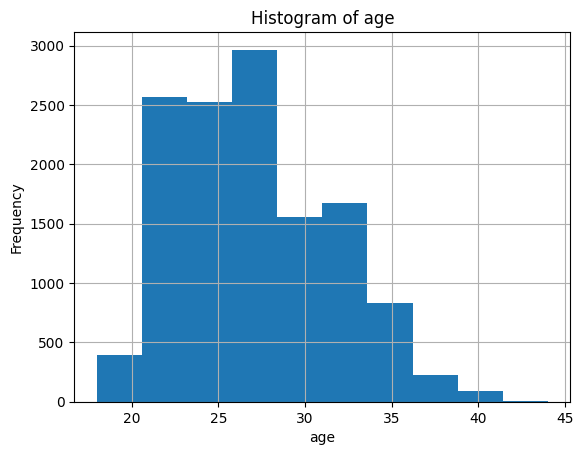

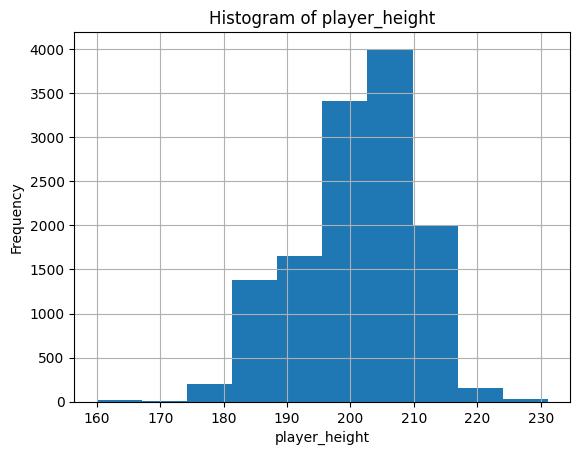

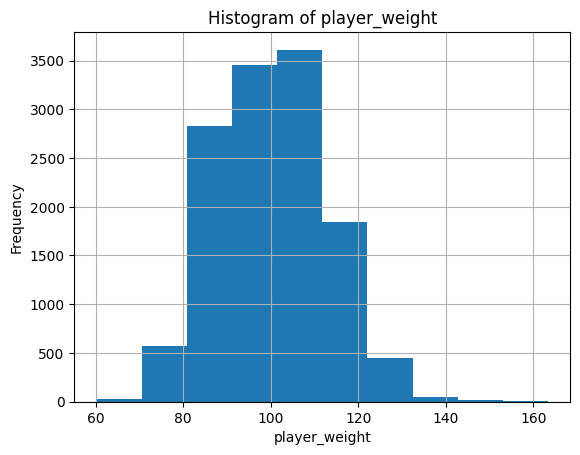

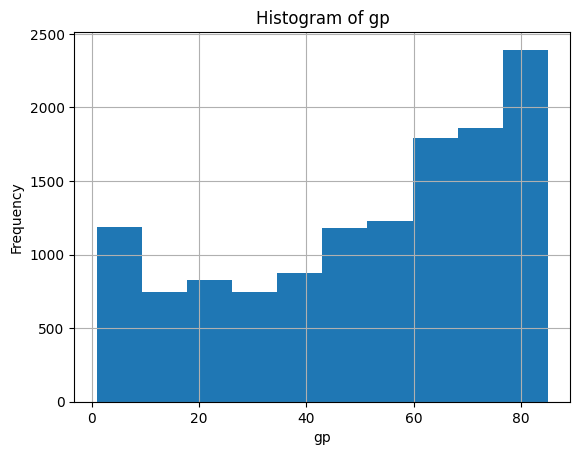

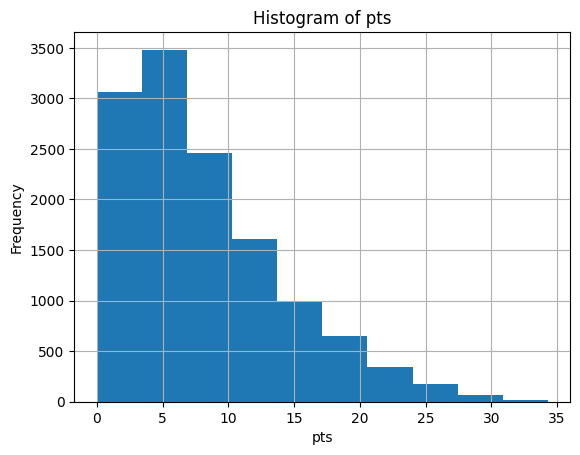

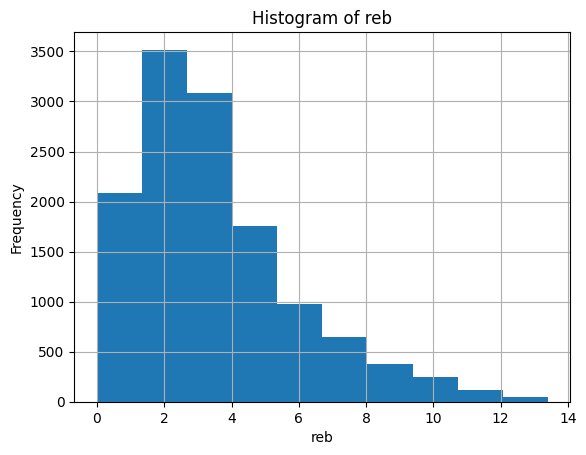

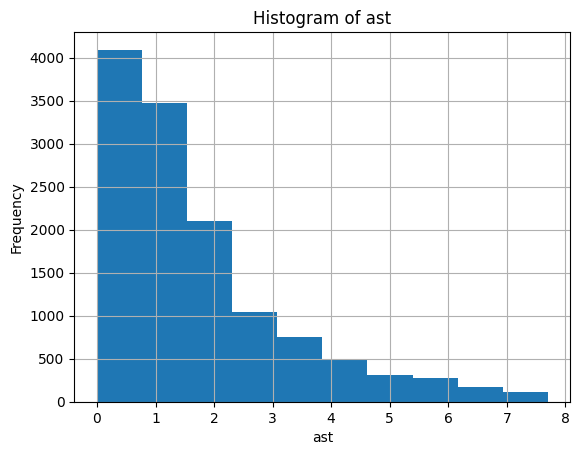

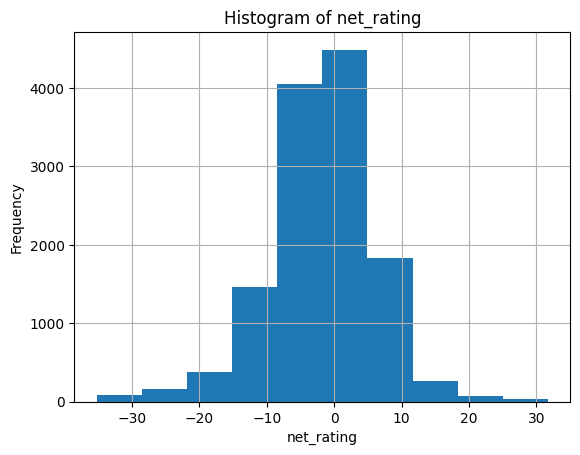

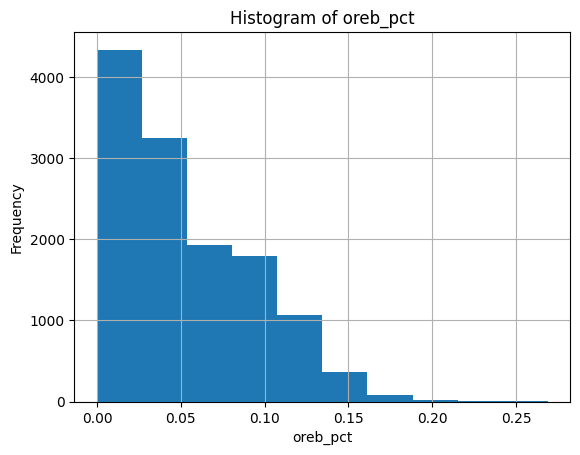

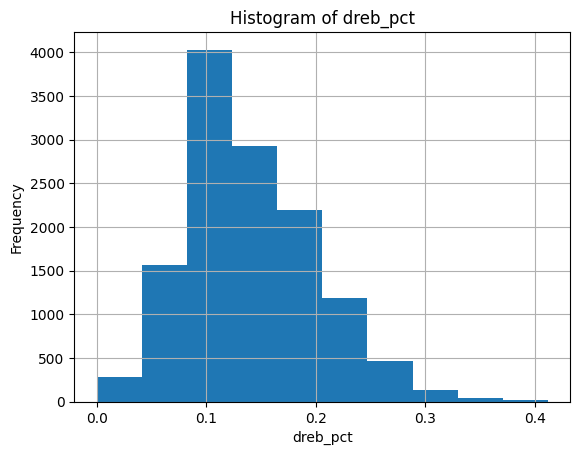

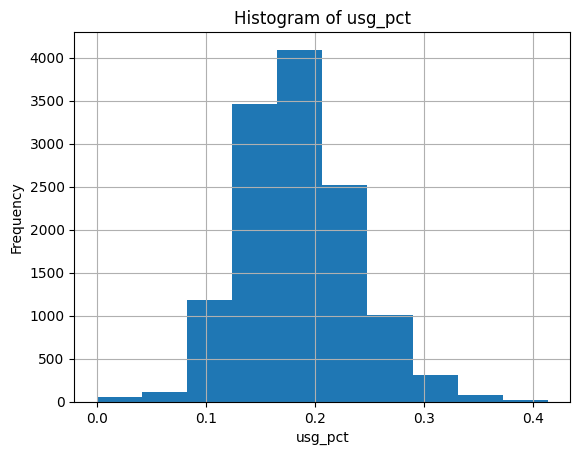

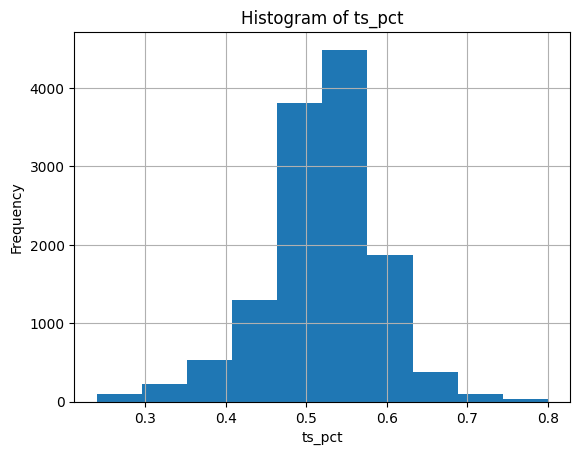

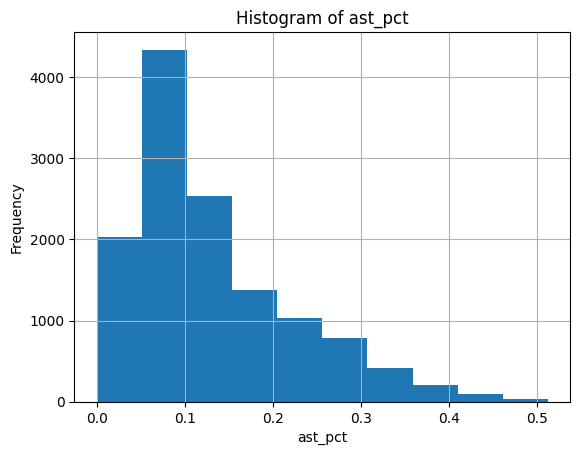

In [14]:
#Distribuição das Variáveis

numeric_cols = ['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']
for col in numeric_cols:
    plt.figure()
    all_seasons[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

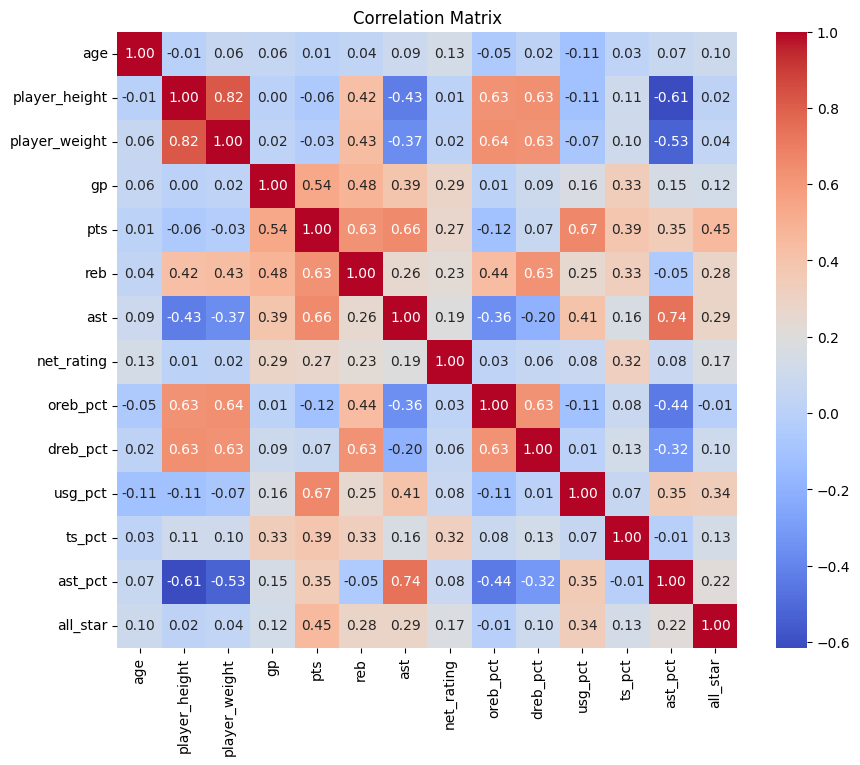

In [15]:
# Excluindo as colunas não numéricas
all_seasons_numeric = data
correlation_matrix = all_seasons_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

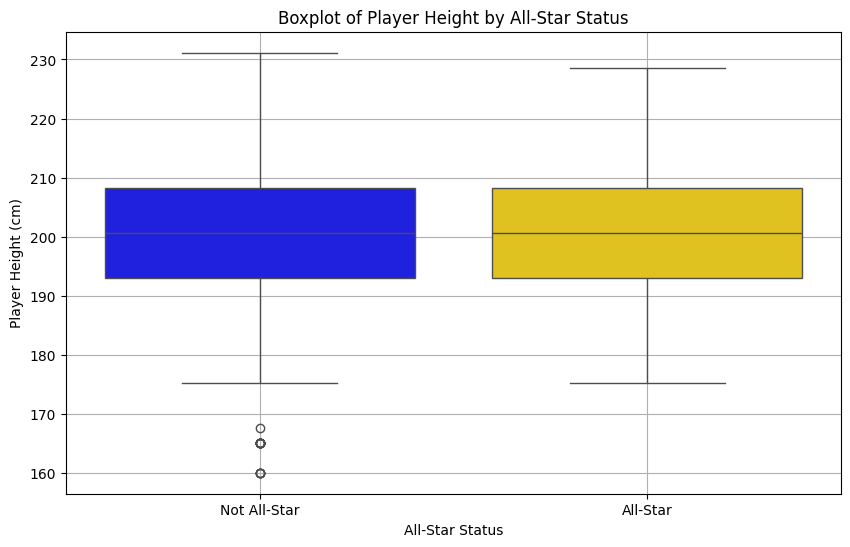

In [16]:
# Gerar um boxplot para a altura dos jogadores
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='all_star', y='player_height', hue='all_star', data=all_seasons, palette={0: 'blue', 1: 'gold'}, dodge=False)
plt.title('Boxplot of Player Height by All-Star Status')
plt.xlabel('All-Star Status')
plt.ylabel('Player Height (cm)')
plt.xticks([0, 1], ['Not All-Star', 'All-Star'])

# Como 'hue' e 'x' são os mesmos, podemos esconder a legenda redundante
plt.legend([],[], frameon=False)

plt.grid(True)
plt.show()

**Observações:**

As variáveis de altura e peso possuem a maior correlação, o que faz sentido, dado que os jogadores com as maiores alturas costumam ser, de fato, os mais pesados.

As variáveis de assistência e porcentagem de assistências também possuim um valor de correlação considerável, mas ambas serão utilizadas dado que suas finalidades são distintas: a coluna "ast_pct" mede a porcentagem de assistências do jogador em relação ao total do time na temporada, enquanto "ast" é simplesmente a média da quantidade de assistências por partida do jogador.

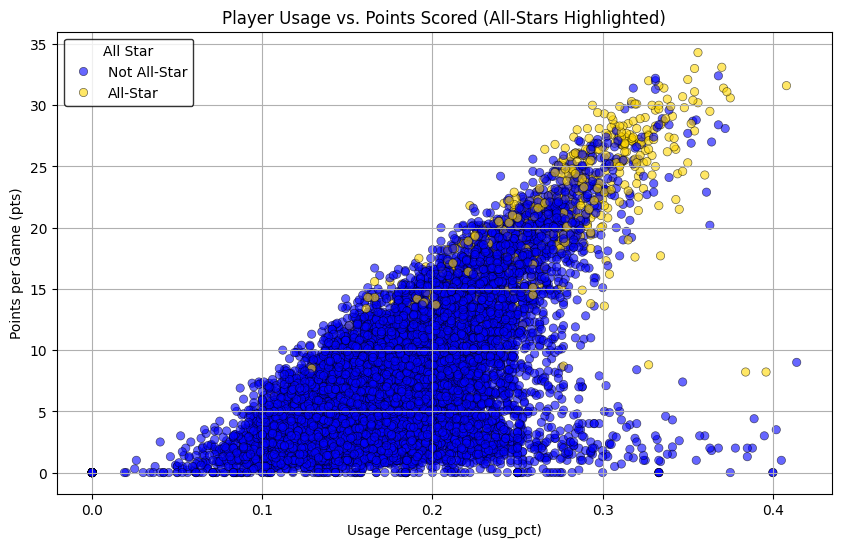

In [17]:
#gráfico de dispersão que mostre a pontuação média (pts) versus a porcentagem de uso (usg_pct) para jogadores,
#destacando aqueles que foram All-Stars em comparação com aqueles que não foram.
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='usg_pct', y='pts', hue='all_star', palette={0: 'blue', 1: 'gold'}, data=all_seasons, alpha=0.6, edgecolor='black')

# Ajustes na legenda para corresponder às cores corretas
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles, ['Not All-Star', 'All-Star'], title='All Star', loc='upper left', frameon=True, facecolor='white', edgecolor='black')

plt.title('Player Usage vs. Points Scored (All-Stars Highlighted)')
plt.xlabel('Usage Percentage (usg_pct)')
plt.ylabel('Points per Game (pts)')
plt.grid(True)
plt.show()


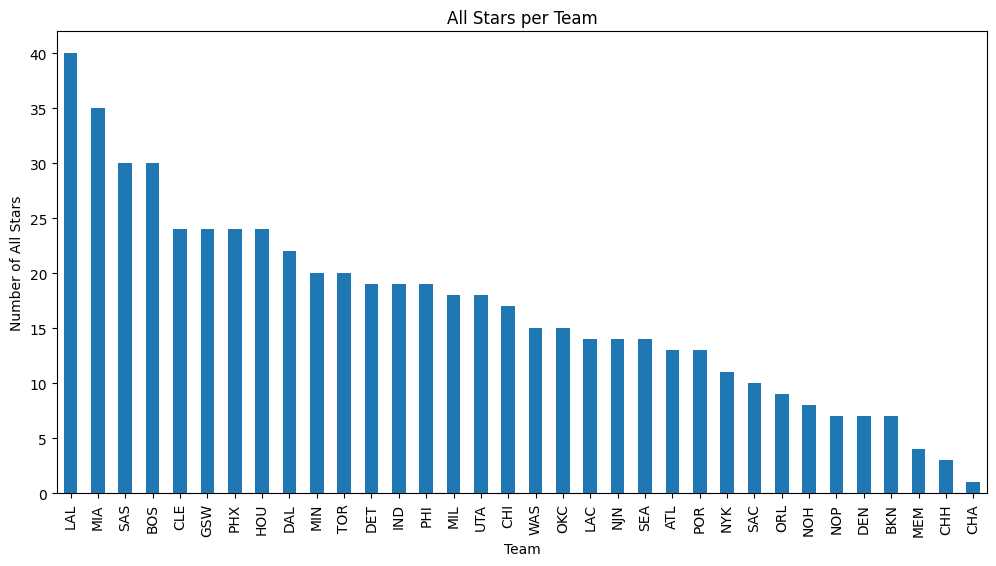

In [18]:
all_star_counts = all_seasons[all_seasons['all_star'] == 1]['team_abbreviation'].value_counts()
plt.figure(figsize=(12, 6))
all_star_counts.plot(kind='bar')
plt.title('All Stars per Team')
plt.xlabel('Team')
plt.ylabel('Number of All Stars')
plt.show()

In [19]:
# Importando bibliotecas necessárias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

# Definindo as features e o target (assumindo que 'all_star' é o alvo)
X = data.drop(columns=['all_star'])  # Features
y = data['all_star']  # Target

# Dividindo os dados em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

